# Jupyter Notebook for Task 4: Modeling



## Preperation
Before we start modeling, we have to load the packages and the data, and prepare it so it can be processed by the models.

In [23]:
# Import standard libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Polynomial regression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

# Neural network
from keras import Sequential  # Sequential model: https://keras.io/guides/sequential_model/
from keras.layers import Dense, Dropout, BatchNormalization

# Import custom functions and utilities
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer

# Time series analysis
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Environment settings
import os
os.environ["KERAS_BACKEND"] = "torch"
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Matplotlib settings
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29717 entries, 2018-04-25 04:00:00-07:00 to 2021-09-14 08:00:00-07:00
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   activeSessions_site2     29717 non-null  int64  
 1   utilizationRate_site2    29717 non-null  float64
 2   kWhDelivered_site2       29717 non-null  float64
 3   idleRate_site2           29717 non-null  float64
 4   blockedRate_site2        29717 non-null  float64
 5   activeSessions_site1     29717 non-null  int64  
 6   utilizationRate_site1    29717 non-null  float64
 7   kWhDelivered_site1       29717 non-null  float64
 8   idleRate_site1           29717 non-null  float64
 9   blockedRate_site1        29717 non-null  float64
 10  activeSessions_total     29717 non-null  int64  
 11  kWhDelivered_total       29717 non-null  float64
 12  utilizationRate_total    29717 non-null  float64
 13  idleRate_total           2971

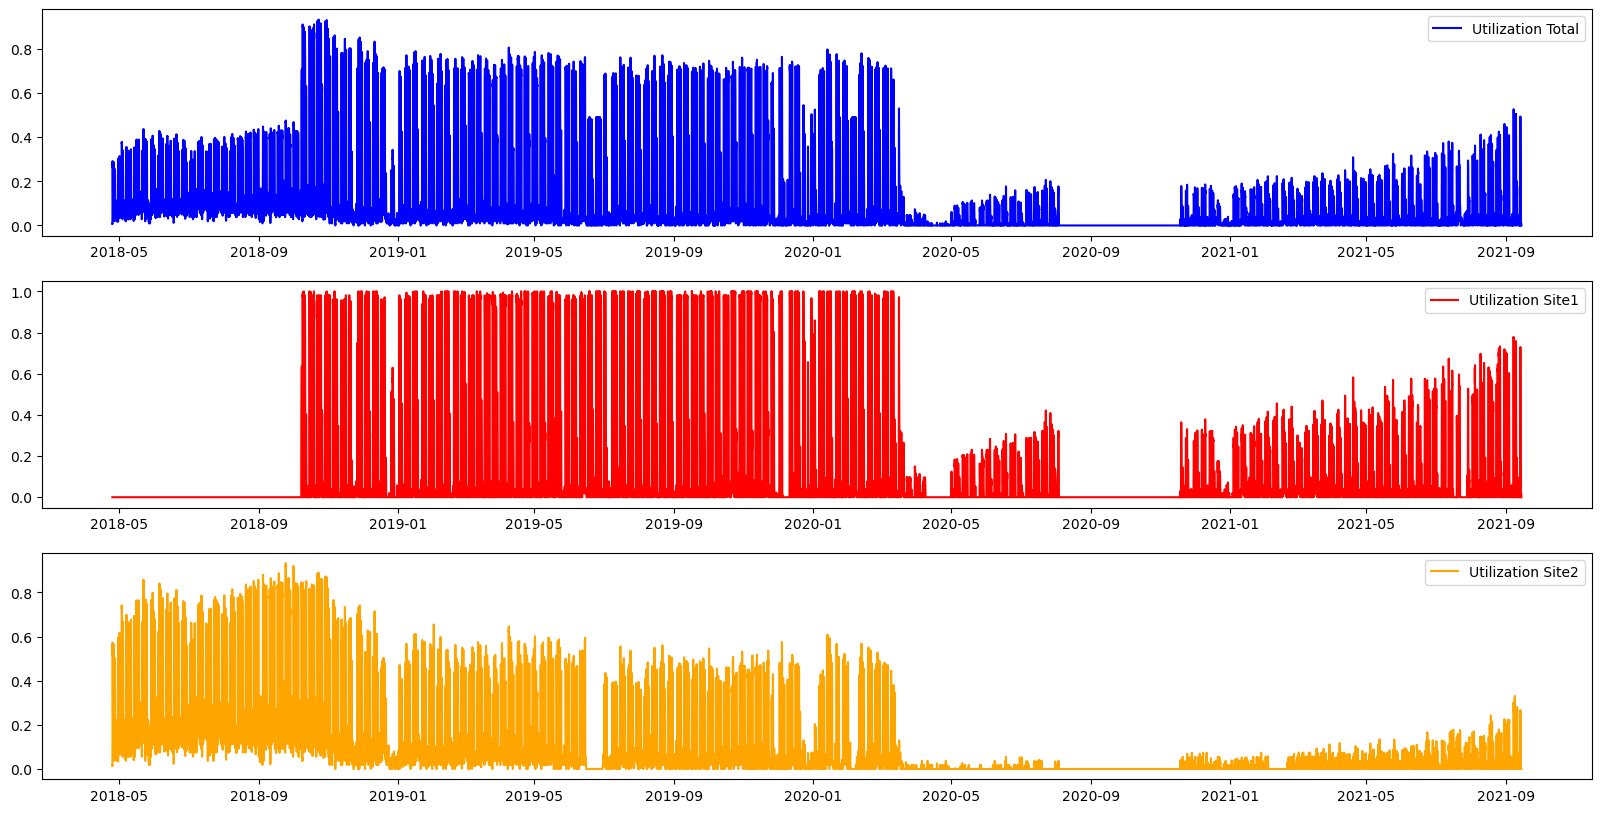

In [24]:
agg_charging_data = pd.read_pickle(os.path.join('Data', 'aggregated_data.pkl'))
agg_charging_data['year'] = agg_charging_data.index.year

plt.figure(figsize=(20, 10))
plt.subplot(3, 1, 1)
plt.plot(agg_charging_data.index, agg_charging_data['utilizationRate_total'], label='Utilization Total', color='blue')
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(agg_charging_data.index, agg_charging_data['utilizationRate_site1'], label='Utilization Site1', color='red')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(agg_charging_data.index, agg_charging_data['utilizationRate_site2'], label='Utilization Site2', color='orange')
plt.legend()

agg_charging_data.info(20)

If we plot the utilization over time, we can observe some interesting pattern. The Strong dip at around 03/2020 can be explained with the corona pandamic. Besides there is a time frame with no values. The objective for this task (based on the Data mining goal) is to predict the untilization of the sites for a short term after the data ends (10/2021). This is why training the models  on these extraordinary events is not feasable, which is why we are onlyusing the data frm after the data hole.

In [25]:
# start_date = pd.Timestamp('2020-11-19', tz='UTC')
# agg_charging_data = agg_charging_data.loc[start_date:]
 
agg_charging_data = agg_charging_data[agg_charging_data['year'] == 2021]
agg_charging_data['week_of_year'] = agg_charging_data['week_of_year'].astype('int32')

Define the model properties:

1. Input features: hour_of_day, day_of_week, month_of_year, year
    - Why these features: We cannot use real-time or future-dependent inputs unless they are forecasted or modeled beforehand. That is why we can obly deterministic values for our prediction.
2. Target features: utilizationRate_siteX
3. Model parameters: Coefficients (θ) for polynomial regression or weights (𝑊,𝑏) for neural network.
4. Hypothesis function: Polynomial regression: 𝑦^=ℎ𝜃(𝑋), Neural network: y^=f(W,b).
5. Objective funktion: Mean Squared Error (MSE): J(θ)=1/m*∑(y^−y)^2.

In [26]:
#different data sets to train the models
gesamt_charging_data = agg_charging_data[['utilizationRate_total', 'hour_of_day', 'day_of_week', 'year', 'month_of_year']]
site1_charging_data = agg_charging_data[['utilizationRate_site1', 'hour_of_day', 'day_of_week', 'year', 'month_of_year']]
site2_charging_data = agg_charging_data[['utilizationRate_site2', 'hour_of_day', 'day_of_week', 'year', 'month_of_year']]

# Is weekend hinzufügen
# Daten aufteilen
X = gesamt_charging_data[['hour_of_day', 'day_of_week', 'month_of_year', 'year']]
y = gesamt_charging_data['utilizationRate_total']
print(X.head())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False) #shuffle = False ensures to split the data in order
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X, y, test_size=0.1, shuffle=False) #shuffle = False ensures to split the data in order
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X, y, test_size=0.1, shuffle=False) #shuffle = False ensures to split the data in order

                           hour_of_day  day_of_week  month_of_year  year
start_hour                                                              
2021-01-01 00:00:00-08:00            0            4              1  2021
2021-01-01 01:00:00-08:00            1            4              1  2021
2021-01-01 02:00:00-08:00            2            4              1  2021
2021-01-01 03:00:00-08:00            3            4              1  2021
2021-01-01 04:00:00-08:00            4            4              1  2021


## Neural Network

In [27]:
from sklearn.preprocessing import MinMaxScaler

# Daten skalieren
scaler = StandardScaler()
X_train_nn = scaler.fit_transform(X_train_nn)
X_test_nn = scaler.transform(X_test_nn)

In [28]:
# Modell erstellen
model = Sequential([
    Dense(32, activation='relu', input_dim=X_train_nn.shape[1]),
    Dense(16, activation='relu'),
    Dense(1)  # Für die Vorhersage eines kontinuierlichen Wertes
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Modell trainieren
history = model.fit(X_train_nn, y_train_nn, epochs=50, batch_size=32, validation_split=0.2, shuffle=False)

Epoch 1/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0060 - mae: 0.0575 - val_loss: 0.0091 - val_mae: 0.0774
Epoch 2/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0050 - mae: 0.0525 - val_loss: 0.0086 - val_mae: 0.0750
Epoch 3/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0030 - mae: 0.0415 - val_loss: 0.0084 - val_mae: 0.0747
Epoch 4/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0023 - mae: 0.0363 - val_loss: 0.0085 - val_mae: 0.0746
Epoch 5/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0017 - mae: 0.0312 - val_loss: 0.0090 - val_mae: 0.0766
Epoch 6/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0014 - mae: 0.0280 - val_loss: 0.0094 - val_mae: 0.0777
Epoch 7/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0012 - mae: 0.0260 - val_loss: 0.0098 - val_mae: 0.0781
Epoch 8/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011 - mae: 0.0243 - val_loss: 0.0100 - val_mae: 0.0785
Epoch 9/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - lo

In [29]:
#check the overview of the training and validation loss 
history_df = pd.DataFrame(history.history)
history_df

,loss,mae,val_loss,val_mae
0,0.004209,0.047803,0.009119,0.077372
1,0.003041,0.040554,0.008574,0.075027
2,0.002234,0.034869,0.008441,0.074688
3,0.001906,0.032125,0.008482,0.074613
4,0.001645,0.029589,0.009009,0.076633
5,0.001477,0.027731,0.009447,0.077716
6,0.001380,0.026599,0.009754,0.078137
7,0.001306,0.025643,0.010035,0.078526
8,0.001266,0.025068,0.010201,0.078558
9,0.001236,0.024646,0.010414,0.078771


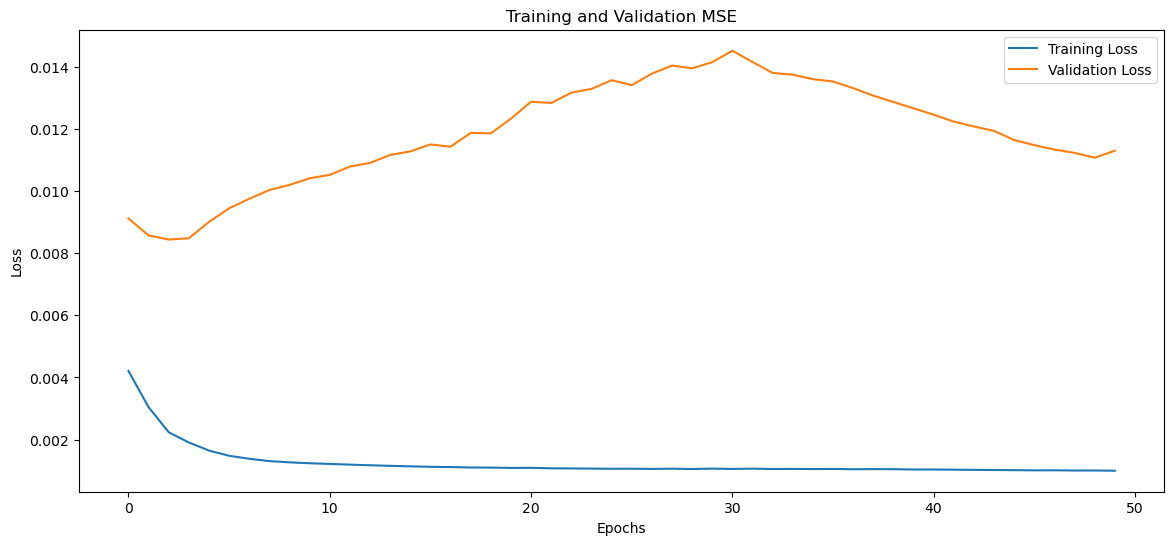

In [30]:
# Plot training and validation loss to see the differences in each epoch
plt.figure(figsize=(14, 6))

plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation MSE')

plt.show()

In [31]:
# Vorhersagen
y_pred_nn = model.predict(X_test_nn)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [32]:
#Measure performance
mse_nn = mean_squared_error(y_test_nn, y_pred_nn)
mae_nn = mean_absolute_error(y_test_nn, y_pred_nn)
r2_nn = r2_score(y_test_nn, y_pred_nn)
print(f"Neural Network - MSE: {mse_nn}, MAE: {mae_nn}, R²: {r2_nn}")

Neural Network - MSE: 0.01995799600819878, MAE: 0.10209117778498913, R²: 0.01707070039471903


In [33]:
# Modell erstellen
model_retrain = Sequential([
    Dense(32, activation='relu',  input_dim=X_train_nn.shape[1]),
    Dense(16, activation='relu'),
    Dense(1)  # Für die Vorhersage eines kontinuierlichen Wertes
])

model_retrain.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Modell trainieren
history = model_retrain.fit(X_train_nn, y_train_nn, epochs=5, batch_size=32, validation_split=0.2, shuffle=False)

Epoch 1/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0174 - mae: 0.0895 - val_loss: 0.0106 - val_mae: 0.0852
Epoch 2/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0023 - mae: 0.0361 - val_loss: 0.0090 - val_mae: 0.0769
Epoch 3/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0015 - mae: 0.0282 - val_loss: 0.0087 - val_mae: 0.0747
Epoch 4/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0014 - mae: 0.0274 - val_loss: 0.0087 - val_mae: 0.0740
Epoch 5/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0014 - mae: 0.0278 - val_loss: 0.0087 - val_mae: 0.0736


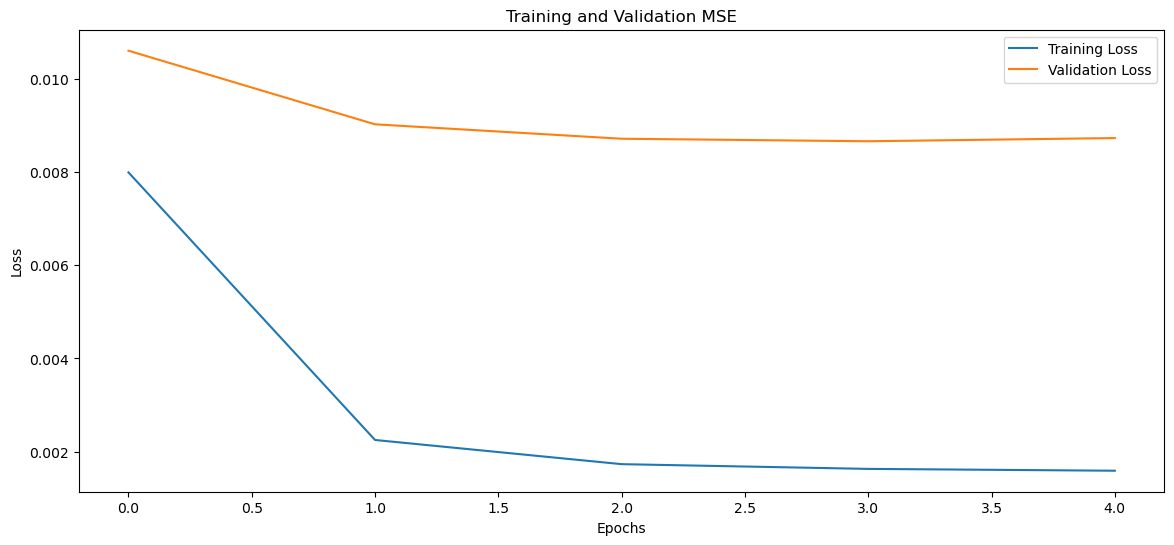

In [34]:
#check the overview of the training and validation loss 
history_df = pd.DataFrame(history.history)

# Plot training and validation loss to see the differences in each epoch
plt.figure(figsize=(14, 6))

plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation MSE')

plt.show()

In [35]:
# Vorhersagen
y_pred_nn = model_retrain.predict(X_test_nn)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [36]:
#Measure performance
mse_nn = mean_squared_error(y_test_nn, y_pred_nn)
mae_nn = mean_absolute_error(y_test_nn, y_pred_nn)
r2_nn = r2_score(y_test_nn, y_pred_nn)
print(f"Neural Network - MSE: {mse_nn}, MAE: {mae_nn}, R²: {r2_nn}")

Neural Network - MSE: 0.012956907126699614, MAE: 0.09288197482846093, R²: 0.36187362489371844


## Polynomial regression

First, lets prepare the training and data set. To find the right degree, we train the model on a rage from 1 to 20.

In [37]:
# Define the pipeline
pipeline = Pipeline([
    ('polynomial_features', PolynomialFeatures()),  # Leave degree as a hyperparameter
    ('scaler', StandardScaler()),                  # Standardize features
    ('ridge_regression', Ridge())                  # Ridge regression with L2 regularization
])

# Define the hyperparameter grid
param_grid = {
    'polynomial_features__degree': range(11),  # Polynomial degrees
    'ridge_regression__alpha': np.logspace(-3, 2, 5)    # Regularization strengths
}

# Define the scoring metric
scorer = make_scorer(mean_absolute_error, greater_is_better=False)
kf = KFold(n_splits=5, shuffle=False)

# Perform GridSearchCV using the training set and validation set
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=kf,
    scoring=scorer,
)

# Fit the grid search on the training data
grid_search.fit(X_train_poly, y_train_poly)

# Get the best hyperparameters and corresponding score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # Negate since we used negative MSE as the scoring

print(f"Best Parameters: {best_params}")
print(f"Best Mean Squared Error (Validation Set, Cross-Validation): {best_score}")

# Validate the best model on the separate validation set
best_model_poly = grid_search.best_estimator_

# Final evaluation on the test set
y_pred_poly = best_model_poly.predict(X_test_poly)

mse_poly = mean_squared_error(y_test_poly, y_pred_poly)
mae_poly = mean_absolute_error(y_test_poly, y_pred_poly)
r2_poly = r2_score(y_test_poly, y_pred_poly)


Best Parameters: {'polynomial_features__degree': 5, 'ridge_regression__alpha': np.float64(0.31622776601683794)}
Best Mean Squared Error (Validation Set, Cross-Validation): 0.029108070894891248


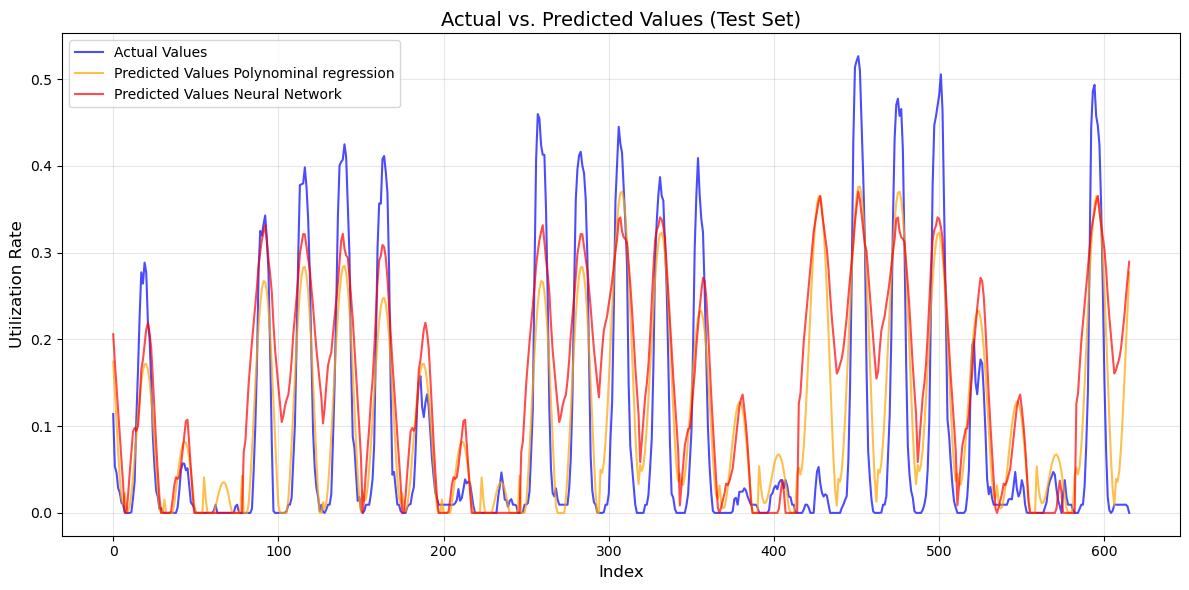

Neural Network - MSE: 0.012956907126699614, MAE: 0.09288197482846093, R²: 0.36187362489371844
Polynomial Regression - MSE: 0.0065029005956450565, MAE: 0.0578837308447615, R²: 0.6797327985608195


In [38]:
# Vohersagen plotten
# Index erstellen, um die Testdaten in der Reihenfolge darzustellen
indices = np.arange(len(y_test_poly))

plt.figure(figsize=(12, 6))

# Tatsächliche Werte plotten
plt.plot(indices, y_test, label='Actual Values', color='blue', linestyle='-', alpha=0.7)

#replace negative values with null 
y_pred_nn = np.maximum(0, y_pred_nn)
y_pred_poly = np.maximum(0, y_pred_poly)

# Vorhergesagte Werte plotten
plt.plot(indices, y_pred_poly, label='Predicted Values Polynominal regression', color='orange', linestyle='-', alpha=0.7)
plt.plot(indices, y_pred_nn, label='Predicted Values Neural Network', color='red', linestyle='-', alpha=0.7)

# Titel und Achsenbeschriftungen
plt.title("Actual vs. Predicted Values (Test Set)", fontsize=14)
plt.xlabel("Index", fontsize=12)
plt.ylabel("Utilization Rate", fontsize=12)

# Legende und Gitter
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# Plot anzeigen
plt.show()
print(f"Neural Network - MSE: {mse_nn}, MAE: {mae_nn}, R²: {r2_nn}")
print(f"Polynomial Regression - MSE: {mse_poly}, MAE: {mae_poly}, R²: {r2_poly}")


The comparison indicates a better performance of the polynominal regression, likely because of the limited complexity. Lets use the model to predict the next weeks utilization.

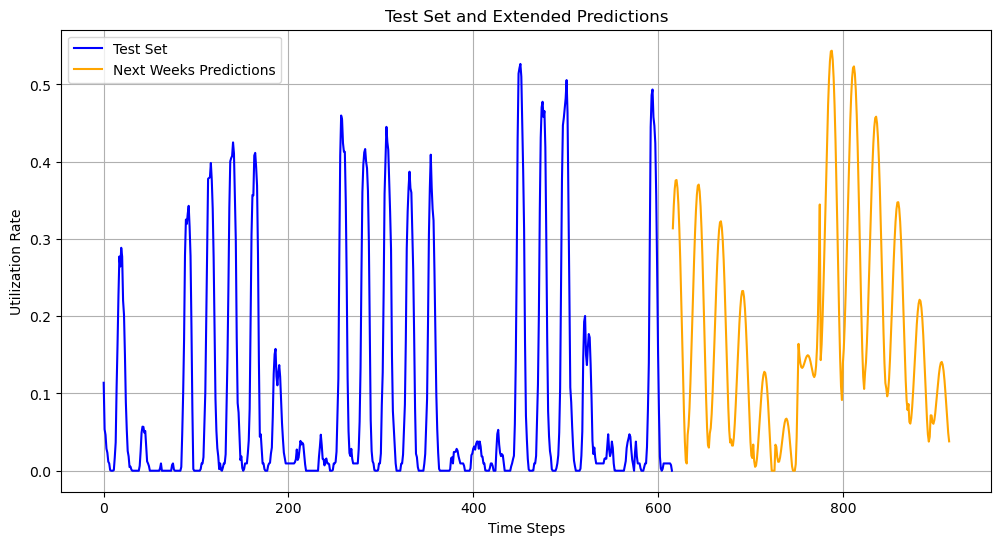

In [39]:
# Convert X_test back to a DataFrame if it's a NumPy array
if not isinstance(X_test, pd.DataFrame):
    X_test = pd.DataFrame(X_test, columns=['hour_of_day', 'day_of_week', 'month_of_year', 'year'])

# Extend the test set one month forward
def extend_test_set(X_test, n_steps=24):
    extended_test_set = pd.DataFrame()  # Initialize an empty DataFrame
    last_row = X_test.iloc[-1].copy()  # Start from the last row
    extended_rows = []
    for _ in range(n_steps):  # Simulate the next 'n_steps' rows
        last_row['hour_of_day'] += 1
        if last_row['hour_of_day'] > 24:  # Reset hour_of_day and increment day_of_week
            last_row['hour_of_day'] = 1
            last_row['day_of_week'] += 1
        if last_row['day_of_week'] > 7:  # Reset day_of_week and increment month_of_year
            last_row['day_of_week'] = 1
            last_row['month_of_year'] += 1
        if last_row['month_of_year'] > 12:  # Reset month_of_year and increment year
            last_row['month_of_year'] = 1
            last_row['year'] += 1
        extended_rows.append(last_row.copy())  # Add the new row
    
    extended_test_set = pd.concat([extended_test_set, pd.DataFrame(extended_rows)], ignore_index=True)
    return extended_test_set

# Generate extended test set
X_test_extended = extend_test_set(X_test, n_steps=300)

# Predict on the extended test set
y_extended_pred = best_model_poly.predict(X_test_extended)
y_extended_pred = np.maximum(0, y_extended_pred)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Test Set', color='blue')
plt.plot(range(len(y_test), len(y_test) + len(y_extended_pred)), y_extended_pred, label='Next Weeks Predictions', color='orange')
plt.xlabel("Time Steps")
plt.ylabel("Utilization Rate")
plt.title("Test Set and Extended Predictions")
plt.legend()
plt.grid(True)
plt.show()

## Time series: ARIMA

The models performance are satisfying and show the basic structure and Trend of the data, but the predictive performance is not optimal. Because we rely on time dependent data, we also tested the use of an ARIMA model, which focusses on time series.

### Load and prepare the data

                     utilizationRate_total
start_hour                                
2021-01-01 00:00:00               0.002005
2021-01-01 01:00:00               0.002005
2021-01-01 02:00:00               0.002005
2021-01-01 03:00:00               0.002005
2021-01-01 04:00:00               0.002005
0
(6152, 1)


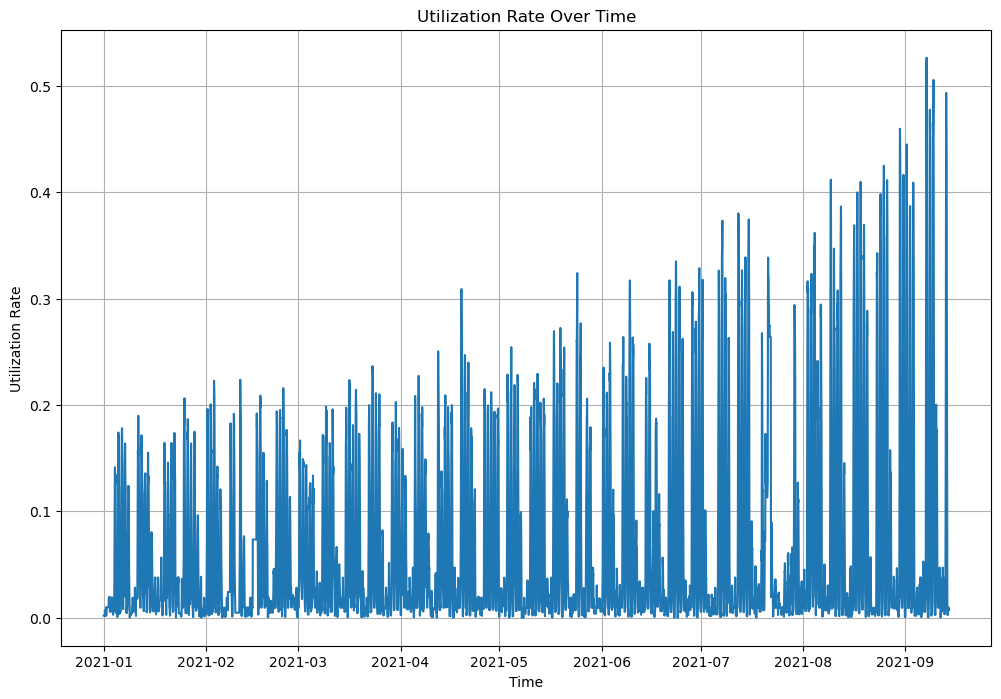

In [40]:
# Select 'utilizationRate_total' column from the DataFrame
data = agg_charging_data[['utilizationRate_total']]  # This keeps it as a DataFrame, not a Series

data.index = pd.to_datetime(data.index)

data.index.freq = 'H'

data['utilizationRate_total'].replace(0, np.nan, inplace=True)
data['utilizationRate_total'].fillna(method='bfill', inplace=True)
data['utilizationRate_total'].fillna(method='ffill', inplace=True)

data.index = pd.to_datetime(data.index).tz_localize(None)

# Now 'data' is a DataFrame, so you can work with it directly
print(data.head())
print(data['utilizationRate_total'].isna().sum())
print(data.shape)
# Plot the DataFrame
plt.plot(data)
plt.title('Utilization Rate Over Time')
plt.xlabel('Time')
plt.ylabel('Utilization Rate')
plt.grid(True)
plt.show()

### Check stationarity
We use statistic tests like the Dicky Fuller test to determine if the series is stationary. This is necessary to be able for the model to be processed

In [41]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=168).mean()
    rolstd = timeseries.rolling(window=168).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:\n')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

### Data transformation and decomposion

In [42]:
ts_log = np.log(data['utilizationRate_total'])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6152 entries, 2021-01-01 00:00:00 to 2021-09-14 08:00:00
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   seasonal_24   6152 non-null   float64
 1   seasonal_168  6152 non-null   float64
dtypes: float64(2)
memory usage: 144.2 KB
None


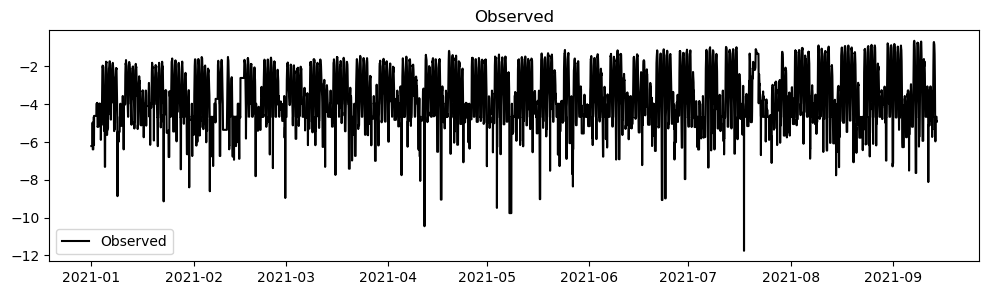

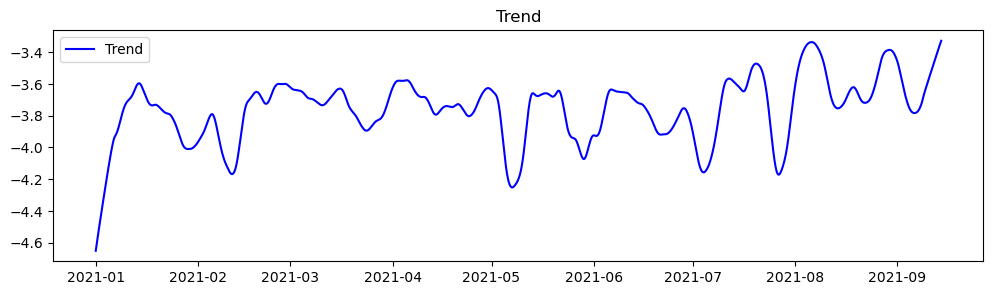

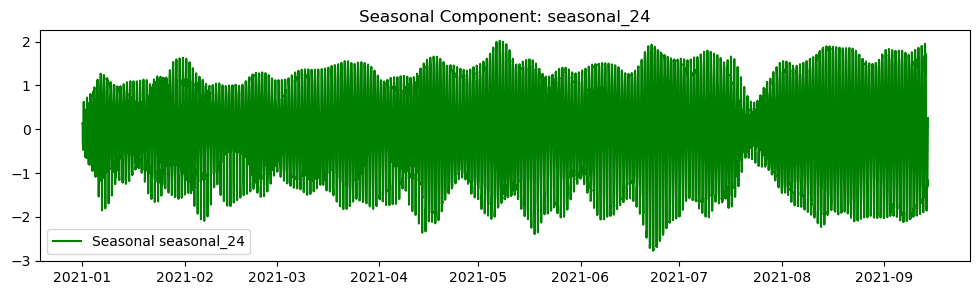

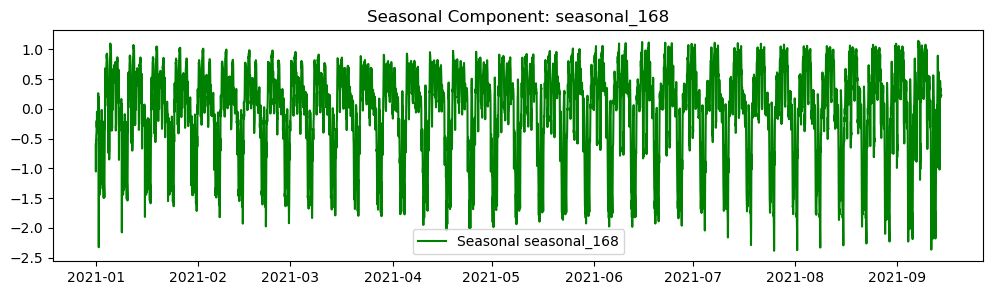

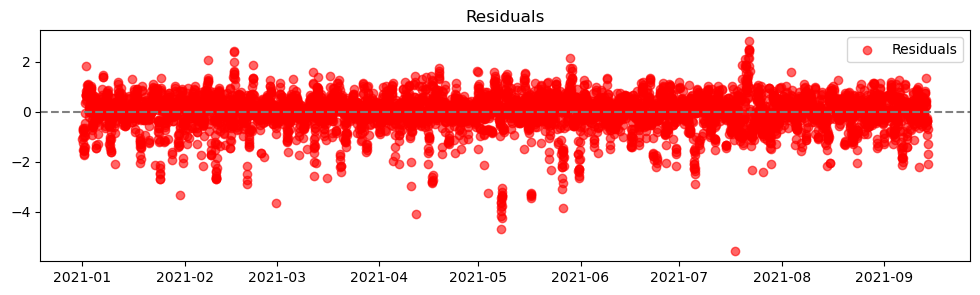

In [43]:
res = MSTL(ts_log, periods=(24, 24*7)).fit()
# Komponenten aus dem res-Objekt extrahieren
observed = res.observed
trend = res.trend
seasonal = res.seasonal
residuals = res.resid
print(seasonal.info())
# Plot für die beobachteten Daten
plt.figure(figsize=(12, 3))
plt.plot(observed, label='Observed', color='black')
plt.title('Observed')
plt.legend()

# Plot für den Trend
plt.figure(figsize=(12, 3))
plt.plot(trend, label='Trend', color='blue')
plt.title('Trend')
plt.legend()

# Plot für jede saisonale Komponente
for col in seasonal.columns:
    plt.figure(figsize=(12, 3))
    plt.plot(seasonal[col], label=f'Seasonal {col}', color='green')
    plt.title(f'Seasonal Component: {col}')
    plt.legend()

# Plot für die Residuen
plt.figure(figsize=(12, 3))
plt.scatter(residuals.index, residuals, label='Residuals', color='red', alpha=0.6)
plt.axhline(0, linestyle='--', color='gray')
plt.title('Residuals')
plt.legend()
plt.show()

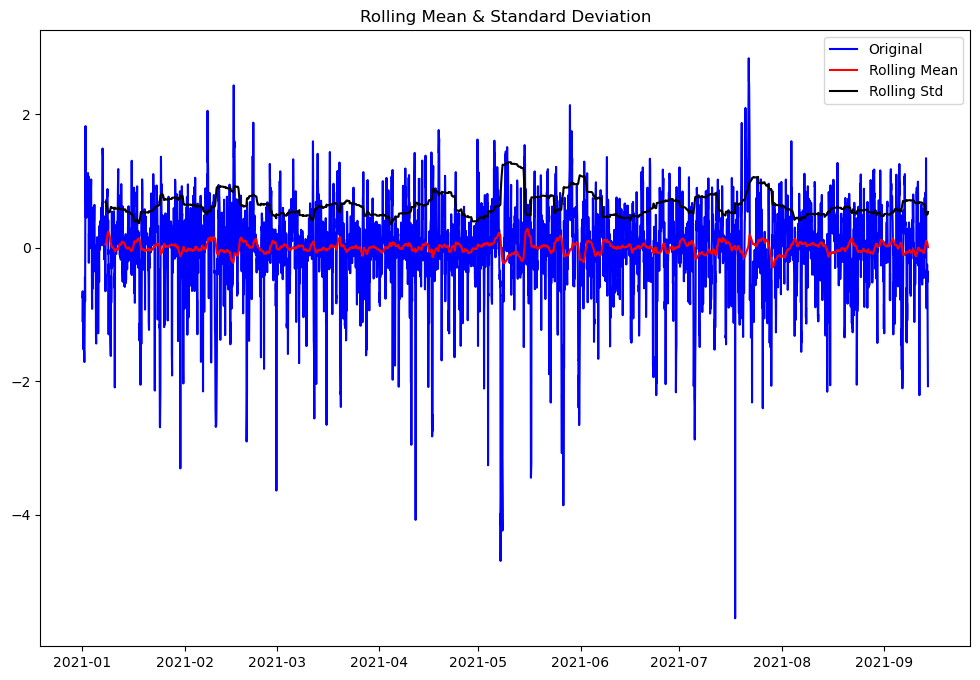

Results of Dickey-Fuller Test:

Test Statistic                -1.558050e+01
p-value                        1.935363e-28
#Lags Used                     2.400000e+01
Number of Observations Used    6.127000e+03
Critical Value (1%)           -3.431418e+00
Critical Value (5%)           -2.862012e+00
Critical Value (10%)          -2.567021e+00
dtype: float64


In [44]:
ts_log_decompose = residuals.copy()
ts_log_decompose.interpolate(method='time', inplace=True)
test_stationarity(ts_log_decompose)

### Determine options
Using ACF and PACF charts to determine the p and q value

Suggested value for p (AR): 3
Suggested value for q (MA): 13


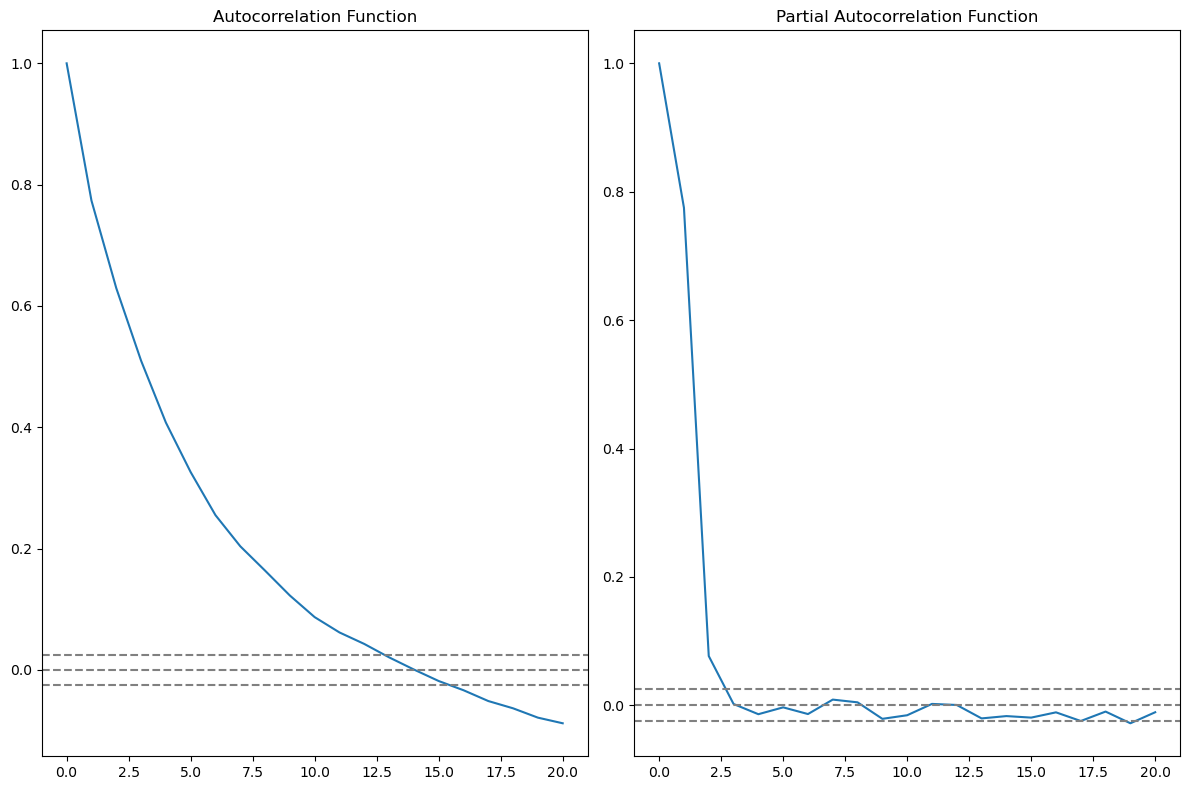

In [45]:
#ACF and PACF plots:
lag_acf = acf(ts_log_decompose, nlags=20)
lag_pacf = pacf(ts_log_decompose, nlags=20, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_decompose)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_decompose)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_decompose)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_decompose)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

# Define confidence interval
conf_interval = 1.96 / np.sqrt(len(ts_log_decompose))

# Determine p (where PACF cuts off sharply)
p = next((i for i, x in enumerate(lag_pacf) if abs(x) < conf_interval and i > 0), None)

# Determine d (use default value of 1)
d = 1

# Determine q (where ACF cuts off sharply)
q = next((i for i, x in enumerate(lag_acf) if abs(x) < conf_interval and i > 0), None)

print(f"Suggested value for p (AR): {p}")
print(f"Suggested value for q (MA): {q}")

### Fitting Arima model

Text(0.5, 1.0, 'RSS: 913.2371')

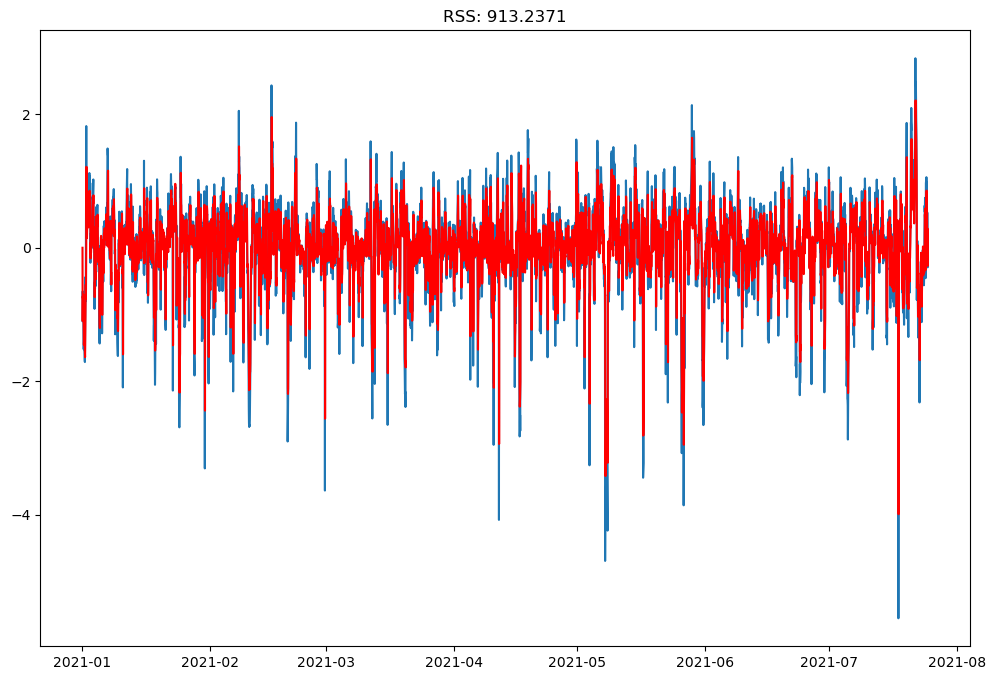

In [46]:
split_ratio = 0.8
train_size = int(len(ts_log_decompose) * split_ratio)
residual_train, residual_test = train_test_split(ts_log_decompose, train_size=train_size, shuffle=False)

model = ARIMA(residual_train, order=(p, d, q))  
results_ARIMA = model.fit() 
plt.plot(residual_train)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-residual_train)**2))

### Forecasting on test set

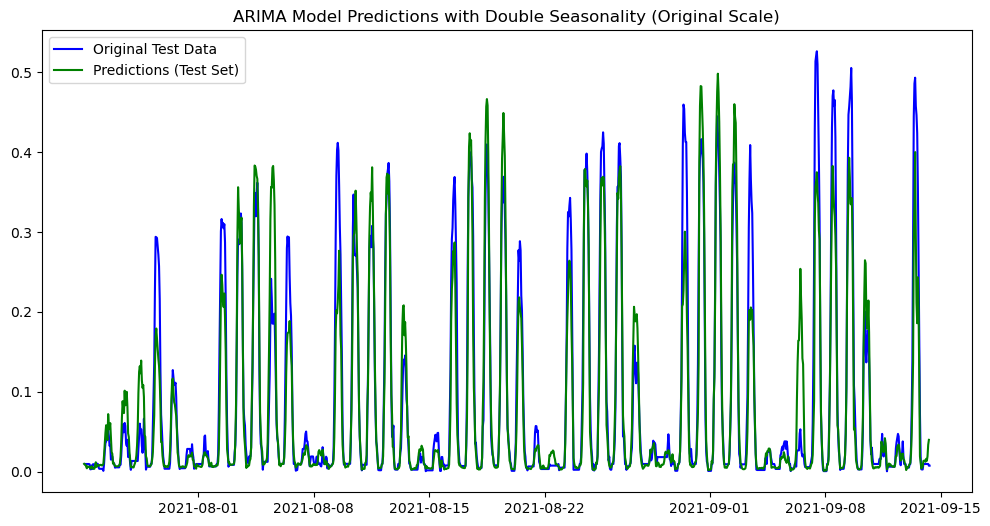

ARIMA model - MSE: 0.003332075812369709, MAE: 0.03214377744491104, R²: 0.7985484399498405


In [47]:
# Ensure frequency and alignment for all components
full_index = pd.date_range(start=residuals.index.min(), end=residuals.index.max(), freq='H')
residuals = residuals.reindex(full_index)
trend = trend.reindex(full_index)
seasonal = seasonal.reindex(full_index)

# Fill missing values and ensure no NaNs
residuals.interpolate(method='time', inplace=True)
trend.interpolate(method='time', inplace=True)
seasonal.interpolate(method='time', inplace=True)

# Set consistent frequency
residuals.index.freq = 'H'
trend.index.freq = 'H'
seasonal.index.freq = 'H'

# Train-test split using slicing
train_size = int(len(residuals) * 0.8)  # 80% train, 20% test
residual_train = residuals.iloc[:train_size]
residual_test = residuals.iloc[train_size:]
trend_train = trend.iloc[:train_size]
trend_test = trend.iloc[train_size:]
seasonal_train_1 = seasonal.iloc[:train_size, 0]
seasonal_test_1 = seasonal.iloc[train_size:, 0]
seasonal_train_2 = seasonal.iloc[:train_size, 1]
seasonal_test_2 = seasonal.iloc[train_size:, 1]

# Predict residuals using ARIMA
residual_predictions = results_ARIMA.predict(start=len(residual_train), end=len(residuals) - 1)
residual_predictions.index = residual_test.index

# Align indices for all components
trend_test.index = residual_test.index
seasonal_test_1.index = residual_test.index
seasonal_test_2.index = residual_test.index

# Ensure predictions match in length
assert len(residual_predictions) == len(trend_test), "Residual predictions length mismatch!"

# Reconstruct predictions (in log scale)
log_predictions = (
    residual_predictions
    + trend_test
    + seasonal_test_1
    + seasonal_test_2
)

# Apply inverse log transformation to return to original scale
full_predictions = np.exp(log_predictions)

# Trim full_predictions to match test data length
full_predictions = full_predictions.iloc[:len(data.iloc[train_size:])]

# Ensure the test set length matches full_predictions
test = data.iloc[train_size:]['utilizationRate_total']
assert len(test) == len(full_predictions), "Final lengths still do not match!"

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test, label="Original Test Data", color='blue')
plt.plot(full_predictions, label="Predictions (Test Set)", color='green')
plt.legend()
plt.title('ARIMA Model Predictions with Double Seasonality (Original Scale)')
plt.show()

# Evaluate the model
mse_arima = mean_squared_error(test, full_predictions)
mae_arima = mean_absolute_error(test, full_predictions)
r2_arima = r2_score(test, full_predictions)

print(f"ARIMA model - MSE: {mse_arima}, MAE: {mae_arima}, R²: {r2_arima}")